### <font color="green" style="calibre">Table of Contents</font>

[<font color="green" size=4.5>1. Importing Necessary Packages and Libraries</font>](#Importing-Necessary-Packages-and-lLbraries)


### <font color="green">1. Importing Necessary Packages and Libraries</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import bz2
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.activations import relu
from keras.losses import binary_crossentropy
from keras.callbacks import History
warnings.filterwarnings('ignore')

%matplotlib inline

2023-10-05 16:52:04.165560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 16:52:05.533293: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 16:52:05.545645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 16:52:16.666036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### <font color="green">2. Loading Data</font>

<p>Since the data is compressed, I have to decompressed it duirng loading</p>

In [2]:
def load_data(file):
    data = bz2.BZ2File(file, "r")
    data = pickle.load(data)
    return data

In [3]:
PATH_TRAIN = '../data/raw/act_train.pbz2'
PATH_TEST = '../data/raw/act_test.pbz2'
PATH_PEOPLE = '../data/raw/people.pbz2'
train = load_data(PATH_TRAIN)
test = load_data(PATH_TEST)
people = load_data(PATH_PEOPLE)

### <font color="green">3. Exploring Data<font>

In [4]:
train.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [5]:
train.tail()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 418,1
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1832,1
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 199,1
2197290,ppl_99994,act2_715089,2023-06-15,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1


In [6]:
train.columns

Index(['people_id', 'activity_id', 'date', 'activity_category', 'char_1',
       'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8',
       'char_9', 'char_10', 'outcome'],
      dtype='object')

In [7]:
row, col = train.shape
print('The length of the train row:', row)
print('The length of the train column:', col)

The length of the train row: 2197291
The length of the train column: 15


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   people_id          object
 1   activity_id        object
 2   date               object
 3   activity_category  object
 4   char_1             object
 5   char_2             object
 6   char_3             object
 7   char_4             object
 8   char_5             object
 9   char_6             object
 10  char_7             object
 11  char_8             object
 12  char_9             object
 13  char_10            object
 14  outcome            int64 
dtypes: int64(1), object(14)
memory usage: 251.5+ MB


In [9]:
train.isna().sum() / train.shape[0] # ratio/percentage of the null values for each attribute

people_id            0.000000
activity_id          0.000000
date                 0.000000
activity_category    0.000000
char_1               0.928268
char_2               0.928268
char_3               0.928268
char_4               0.928268
char_5               0.928268
char_6               0.928268
char_7               0.928268
char_8               0.928268
char_9               0.928268
char_10              0.071732
outcome              0.000000
dtype: float64

<p>We can see clearly below the bottom of the series above that the columns with names "char_#" has
about 93% of its values being null.<br> Let's remove them then.</p>

In [10]:
df = train.dropna(axis=1, ignore_index=True)
df.isna().sum() / df.shape[0]

people_id            0.0
activity_id          0.0
date                 0.0
activity_category    0.0
outcome              0.0
dtype: float64

In [11]:
df.describe(include=[object, int, float, bool])

,people_id,activity_id,date,activity_category,outcome
count,2197291,2197291,2197291,2197291,2.197291e+06
unique,151295,2197291,411,7,NaN
top,ppl_294918,act2_1734928,2022-09-30,type 2,NaN
freq,55103,1,48174,904683,NaN
mean,NaN,NaN,NaN,NaN,4.439544e-01
std,NaN,NaN,NaN,NaN,4.968491e-01
min,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,1.000000e+00


<p>Let's <strong>explore</strong> the people dataframe and see what we've got there too.</p>

In [12]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


In [13]:
people.tail()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
189113,ppl_99987,type 1,group 8600,type 1,2022-04-02,type 4,type 6,type 4,type 3,type 11,...,False,False,False,True,False,True,False,True,True,89
189114,ppl_9999,type 2,group 17304,type 2,2023-02-23,type 6,type 2,type 8,type 3,type 11,...,False,False,False,False,False,False,False,False,False,0
189115,ppl_99992,type 2,group 17304,type 2,2020-06-25,type 5,type 5,type 3,type 4,type 16,...,False,False,False,False,False,False,False,False,False,0
189116,ppl_99994,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,...,True,True,True,True,False,True,True,True,True,95
189117,ppl_99997,type 2,group 17304,type 2,2022-03-12,type 40,type 25,type 9,type 3,type 8,...,False,False,False,False,False,False,False,False,False,36


In [14]:
row, col = people.shape
print('The number of rows in train:', row)
print('The number of columns in train:', col)

The number of rows in train: 189118
The number of columns in train: 41


In [15]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   people_id  189118 non-null  object
 1   char_1     189118 non-null  object
 2   group_1    189118 non-null  object
 3   char_2     189118 non-null  object
 4   date       189118 non-null  object
 5   char_3     189118 non-null  object
 6   char_4     189118 non-null  object
 7   char_5     189118 non-null  object
 8   char_6     189118 non-null  object
 9   char_7     189118 non-null  object
 10  char_8     189118 non-null  object
 11  char_9     189118 non-null  object
 12  char_10    189118 non-null  bool  
 13  char_11    189118 non-null  bool  
 14  char_12    189118 non-null  bool  
 15  char_13    189118 non-null  bool  
 16  char_14    189118 non-null  bool  
 17  char_15    189118 non-null  bool  
 18  char_16    189118 non-null  bool  
 19  char_17    189118 non-null  bool  
 20  char

<p>Let's merge the people data with the train data based on the <strong>peeple_id</strong> as key</p?

In [16]:
merged_df = df.merge(people, on=["people_id"], how="inner")

In [17]:
merged_df.head()

,people_id,activity_id,date_x,activity_category,outcome,char_1,group_1,char_2,date_y,char_3,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,0,type 2,group 17304,type 2,2021-06-29,type 5,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,...,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,...,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,...,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,0,type 2,group 17304,type 2,2021-06-29,type 5,...,False,True,True,False,False,True,True,True,False,36


In [18]:
merged_df.tail()

,people_id,activity_id,date_x,activity_category,outcome,char_1,group_1,char_2,date_y,char_3,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,...,True,True,True,True,False,True,True,True,True,95
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,...,True,True,True,True,False,True,True,True,True,95
2197288,ppl_99994,act2_536973,2023-01-19,type 2,1,type 2,group 17764,type 3,2023-01-06,type 2,...,True,True,True,True,False,True,True,True,True,95
2197289,ppl_99994,act2_688656,2023-05-02,type 4,1,type 2,group 17764,type 3,2023-01-06,type 2,...,True,True,True,True,False,True,True,True,True,95
2197290,ppl_99994,act2_715089,2023-06-15,type 2,1,type 2,group 17764,type 3,2023-01-06,type 2,...,True,True,True,True,False,True,True,True,True,95


In [19]:
# Let's view the unique percentage of the merged dataframe
merged_df_NA_percentage = pd.DataFrame(merged_df.isna().sum() / merged_df.shape[0], columns=["NA_Percentage"])
merged_df_NA_percentage['NA_Percentage'].unique()

array([0.])

In [20]:
# removing duplicated entries/record/instances if any
merged_df = merged_df.drop_duplicates()
merged_df.duplicated().sum()

0

### <font color="green">Feature Engineering<font>

<p>I will begin by extracting the <strong>year</strong>, <strong>month</strong>, and <strong>day</strong> as a separate fetures from the date features<p>

In [21]:
merged_df[["date_x", "date_y"]].head()

,date_x,date_y
0,2023-08-26,2021-06-29
1,2022-09-27,2021-06-29
2,2022-09-27,2021-06-29
3,2023-08-04,2021-06-29
4,2023-08-26,2021-06-29


In [22]:
merged_df = merged_df.rename(columns={"date_x": "activity_date", "date_y": "people_date"})

In [23]:
def extract_year_month_day(df, column_name):
    df[column_name + '_year'] = df[column_name].dt.year
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_day'] = df[column_name].dt.day
    return df


date_columns = ["activity_date", "people_date"]  # Use plural "date_columns" instead of "date_column"
for col in date_columns:
    merged_df[col] = pd.to_datetime(merged_df[col])
    
for col in date_columns:
    extract_year_month_day(merged_df, col)

#removing the date features from the dataframe
merged_df = merged_df.drop(date_columns, axis=1)
    
merged_df.head()

,people_id,activity_id,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,...,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
0,ppl_100,act2_1734928,type 4,0,type 2,group 17304,type 2,type 5,type 5,type 5,...,True,True,False,36,2023,8,26,2021,6,29
1,ppl_100,act2_2434093,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,...,True,True,False,36,2022,9,27,2021,6,29
2,ppl_100,act2_3404049,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,...,True,True,False,36,2022,9,27,2021,6,29
3,ppl_100,act2_3651215,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,...,True,True,False,36,2023,8,4,2021,6,29
4,ppl_100,act2_4109017,type 2,0,type 2,group 17304,type 2,type 5,type 5,type 5,...,True,True,False,36,2023,8,26,2021,6,29


In [24]:
# Let's drop the two IDs since we wont be using them in the model development

merged_df = merged_df.drop(["people_id", "activity_id"], axis=1)

In [25]:
# I had to save the datframe after featue engineering. note that I ahd to compressed the size of the data to save storage

COMPRESSED_FILE_PATH = "../data/merged/merged_df.pbz2"

if not os.path.exists(COMPRESSED_FILE_PATH):
    f = bz2.BZ2File(COMPRESSED_FILE_PATH, "w")
    pickle.dump(merged_df, f)

### <font color="green">Label Encoding</font>

In [26]:
merged_df.dtypes # Let's view the dtype of the merged dataframe

activity_category      object
outcome                 int64
char_1                 object
group_1                object
char_2                 object
char_3                 object
char_4                 object
char_5                 object
char_6                 object
char_7                 object
char_8                 object
char_9                 object
char_10                  bool
char_11                  bool
char_12                  bool
char_13                  bool
char_14                  bool
char_15                  bool
char_16                  bool
char_17                  bool
char_18                  bool
char_19                  bool
char_20                  bool
char_21                  bool
char_22                  bool
char_23                  bool
char_24                  bool
char_25                  bool
char_26                  bool
char_27                  bool
char_28                  bool
char_29                  bool
char_30                  bool
char_31   

In [27]:
# I have to filter off the features with object data type ao as to encode them

columns_to_encode = merged_df.select_dtypes(exclude=[bool, int]).columns
merged_df[columns_to_encode].head()

,activity_category,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,type 4,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
1,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
2,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
3,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
4,type 2,type 2,group 17304,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2


In [28]:
# creating a tranformer object to label encode the object-typed features

transformer = ColumnTransformer([('ordinal_encoder', OrdinalEncoder(), columns_to_encode)], remainder='passthrough')
merged_df_2 = transformer.fit_transform(merged_df)

In [29]:
merged_df_2 = pd.DataFrame(merged_df_2, columns=merged_df.columns)
merged_df_2.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
1502722,1.0,1.0,15126.0,2.0,11.0,6.0,1.0,2.0,24.0,1.0,...,True,False,False,97,2022,8,26,2022,2,5
687057,1.0,0.0,8530.0,0.0,19.0,6.0,6.0,2.0,23.0,0.0,...,False,False,False,78,2022,8,30,2020,7,10
1878491,2.0,1.0,16688.0,2.0,38.0,20.0,4.0,3.0,8.0,1.0,...,True,True,True,91,2023,4,1,2023,4,1
2121713,1.0,1.0,4691.0,1.0,34.0,17.0,8.0,2.0,23.0,2.0,...,False,False,False,0,2022,8,20,2021,10,19


<p>I also need a function to convert the bool-dtyped features to it;s corresponding numeric values</p>

In [30]:
temp_bool_features = []

def modify_bool_columns(df):
    for col in df.columns:
        unique_values = df[col].unique()
        # print(unique_values)
        has_true = False
        has_false = False
        
        for value in unique_values:
            if value is True:
                has_true = True
            elif value is False:
                has_false = True

        if has_true and has_false:
            try:
                temp_bool_features.append(col)
                # print(temp)
                df[col] = df[col].apply(lambda x: int(x == True))
            except ValueError:
                pass
    
    return df


merged_df_3 = modify_bool_columns(merged_df_2)

<p>The year feature is also an integer which we will have to change into a string as a categorical feature and label encode it using the encoder (Ordianl encoder). For now, we'll leave the the day and month as it is.</p>

In [31]:
for col in merged_df_3.columns:
    if "year" in col:
        merged_df_3[col] = merged_df_3[col].astype(str)
        ordinal_encoder = OrdinalEncoder()
        merged_df_3[col] = ordinal_encoder.fit_transform(merged_df_3[col].values.reshape(-1, 1))

merged_df_3.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
1502722,1.0,1.0,15126.0,2.0,11.0,6.0,1.0,2.0,24.0,1.0,...,1,0,0,97,0.0,8,26,2.0,2,5
687057,1.0,0.0,8530.0,0.0,19.0,6.0,6.0,2.0,23.0,0.0,...,0,0,0,78,0.0,8,30,0.0,7,10
1878491,2.0,1.0,16688.0,2.0,38.0,20.0,4.0,3.0,8.0,1.0,...,1,1,1,91,1.0,4,1,3.0,4,1
2121713,1.0,1.0,4691.0,1.0,34.0,17.0,8.0,2.0,23.0,2.0,...,0,0,0,0,0.0,8,20,1.0,10,19


In [32]:
merged_df_3.dtypes

activity_category       object
outcome                 object
char_1                  object
group_1                 object
char_2                  object
char_3                  object
char_4                  object
char_5                  object
char_6                  object
char_7                  object
char_8                  object
char_9                  object
char_10                  int64
char_11                  int64
char_12                  int64
char_13                  int64
char_14                  int64
char_15                  int64
char_16                  int64
char_17                  int64
char_18                  int64
char_19                  int64
char_20                  int64
char_21                  int64
char_22                  int64
char_23                  int64
char_24                  int64
char_25                  int64
char_26                  int64
char_27                  int64
char_28                  int64
char_29                  int64
char_30 

In [33]:
merged_df_3.duplicated().sum()

1049997

In [34]:
merged_df_3 = merged_df_3.drop_duplicates()

In [35]:
merged_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147294 entries, 0 to 2197289
Data columns (total 47 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   activity_category    1147294 non-null  object 
 1   outcome              1147294 non-null  object 
 2   char_1               1147294 non-null  object 
 3   group_1              1147294 non-null  object 
 4   char_2               1147294 non-null  object 
 5   char_3               1147294 non-null  object 
 6   char_4               1147294 non-null  object 
 7   char_5               1147294 non-null  object 
 8   char_6               1147294 non-null  object 
 9   char_7               1147294 non-null  object 
 10  char_8               1147294 non-null  object 
 11  char_9               1147294 non-null  object 
 12  char_10              1147294 non-null  int64  
 13  char_11              1147294 non-null  int64  
 14  char_12              1147294 non-null  int64  
 15  cha

<p>We can see in the above output that after label encoding the object-dtyped of those features is still object, so I have to change it an <strong>int</strong> data type</p>

<p>Note: Converting the data types of the other features with int64 to int32 will also save storage capacity from 420.2+ MB to al ost half of it. Lets find out.</p>

In [36]:
def convert_columns_to_int32(df):
    """
    Convert all columns of a DataFrame to int32 data type.
    
    Args:
        df (pd.DataFrame): The DataFrame to be converted.

    Returns:
        pd.DataFrame: The DataFrame with columns converted to int32.
    """
    try:
        return df.astype('int32')
    except ValueError as e:
        print(f"Error converting columns to int32: {e}")
        return df


merged_df_4 = convert_columns_to_int32(merged_df_3)


In [37]:
merged_df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1147294 entries, 0 to 2197289
Data columns (total 47 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   activity_category    1147294 non-null  int32
 1   outcome              1147294 non-null  int32
 2   char_1               1147294 non-null  int32
 3   group_1              1147294 non-null  int32
 4   char_2               1147294 non-null  int32
 5   char_3               1147294 non-null  int32
 6   char_4               1147294 non-null  int32
 7   char_5               1147294 non-null  int32
 8   char_6               1147294 non-null  int32
 9   char_7               1147294 non-null  int32
 10  char_8               1147294 non-null  int32
 11  char_9               1147294 non-null  int32
 12  char_10              1147294 non-null  int32
 13  char_11              1147294 non-null  int32
 14  char_12              1147294 non-null  int32
 15  char_13              1147294 non-null

<p>Woow, there is it, the total size of the dataframe after merging and datatype conversion is now 214.5 MB.</p>

In [38]:
merged_df_4.sample(4, random_state=2023)

,activity_category,outcome,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,...,char_35,char_36,char_37,char_38,activity_date_year,activity_date_month,activity_date_day,people_date_year,people_date_month,people_date_day
281394,1,0,27129,0,41,23,4,0,3,1,...,1,1,1,58,0,9,6,1,10,2
1943348,1,1,4691,1,34,17,8,2,24,2,...,0,0,0,0,0,9,20,0,5,29
2133754,2,1,600,2,34,17,8,0,11,1,...,1,1,1,94,1,3,3,3,3,3
263900,4,1,5014,2,11,21,1,1,20,1,...,1,1,1,99,1,6,30,3,6,29


### <font color="green">DNN</font>

In [39]:
X = merged_df_4.drop('outcome', axis=1)
y = merged_df_4['outcome']

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1147294, 46)
y shape:  (1147294,)


In [57]:
# Splitting the data into training, testing, and validation sets
# I will be splitting the data into 70, 20, 10 respectively

# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=2023)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=2023)

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)
print('Shape of X_val: ', X_val.shape)
print('Shape of y_val: ', y_val.shape)

Shape of X_train:  (803105, 46)
Shape of y_train:  (803105,)
Shape of X_test:  (309770, 46)
Shape of y_test:  (309770,)
Shape of X_val:  (34419, 46)
Shape of y_val:  (34419,)


In [41]:
# defining the models achitecture

model = Sequential([
    Dense(128, input_shape=(46,), activation=relu),
    Dense(64, activation=relu),
    Dense(32, activation=relu),
    Dense(16, activation=relu),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss=binary_crossentropy,
    metrics=['accuracy'],
)

In [42]:
history = History()

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[history],
)

2023-10-05 16:57:41.982055: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147771320 exceeds 10% of free system memory.


Epoch 1/5
25098/25098 - 123s - loss: 0.7153 - accuracy: 0.8963 - val_loss: 0.1242 - val_accuracy: 0.9379 - 123s/epoch - 5ms/step
Epoch 2/5
25098/25098 - 129s - loss: 0.0445 - accuracy: 0.9879 - val_loss: 4.4568e-05 - val_accuracy: 1.0000 - 129s/epoch - 5ms/step
Epoch 3/5
25098/25098 - 127s - loss: 0.0251 - accuracy: 0.9940 - val_loss: 9.5170e-04 - val_accuracy: 0.9999 - 127s/epoch - 5ms/step
Epoch 4/5
25098/25098 - 124s - loss: 0.0176 - accuracy: 0.9961 - val_loss: 0.0013 - val_accuracy: 1.0000 - 124s/epoch - 5ms/step
Epoch 5/5
25098/25098 - 127s - loss: 0.0294 - accuracy: 0.9936 - val_loss: 0.0013 - val_accuracy: 1.0000 - 127s/epoch - 5ms/step


Text(0.5, 0, 'Epochs')

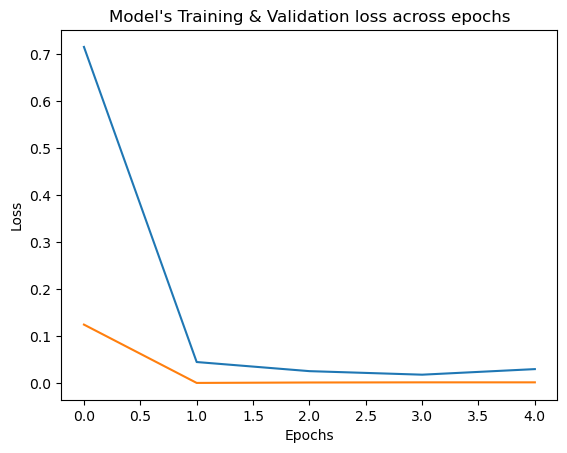

In [43]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')

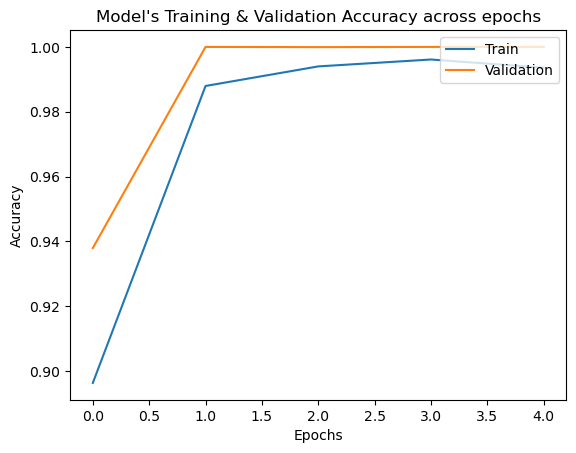

In [44]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title("Model's Training & Validation Accuracy across epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
# lets make some predicitons with the test set
prediction = model.predict(X_test)

9681/9681 [==============================] - 42s 4ms/step


In [58]:
binary_predictions = (prediction >= 0.5).astype(int)
y_test = pd.DataFrame(y_test.values, columns=['Actual Outcome'])
y_test['Predicted Outcome'] = pd.DataFrame(binary_predictions)
y_test.sample(10)

,Actual Outcome,Predicted Outcome
110672,1,1
268488,1,1
250594,0,0
78253,1,1
77059,1,1
175126,1,1
78388,1,1
13941,1,1
210515,1,1
252286,1,1
